# Evaluating Uplift Models

One of the most widespread applications of causal inference in the industry is **uplift modeling**, a.k.a. the estimation of Conditional Average Treatment Effects.

When estimating the causal effect of a **treatment** (a drug, ad, product, ...) on an **outcome** of interest (a disease, firm revenue, customer satisfaction, ...), we are often not only interested in understanding whether the treatment works on average, but we would like to know for which **subjects** (patients, users, customers, ...) it works better or worse. 

The estimation of heterogenous incremental effects, or uplift, is an essential intermediate step in order to improve **targeting** of the policy of interest. For example, we might want to warn certain people that they are more likely to experience side effects from a drug or show an advertisement only to a specific set of customers.

While there exist many methods to model uplift, it is not always clear which one to use in a specific application. Crucially, because of the **fundamental problem of causal inference**, the objective of interest, the uplift, is never observed, and therefore we cannot validate our estimators as we would do with a machine learning prediction algorithm. We cannot set aside a validation set and pick the best-performing model since we have **no ground truth**, not even in the validation set and not even if we ran a randomized experiment.

What can we do then? In this article, I try to cover the most popular methods used to **evaluate uplift models**. If you are not familiar with uplift models, I suggest reading [my introductory article](https://towardsdatascience.com/8a9c1e340832) first.

Enjoy!

## Uplift and Promotional Emails

Imagine we were a product company interested in improving our **email marketing campaing**. Historically, we mostly sent emails to new customers. However, now we would like to adopt a data-driven approach and terget customers for whom the email has the highest positive impact on revenue. This impact is also called **uplift** or **incrementality**.

Let's have a look at the data we have at our disposal.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_promotional_email

In [3]:
dgp = dgp_promotional_email(n=500)
df = dgp.generate_data()
df.head()

,new,age,sales_old,mail,sales
0,0,32.42,0.11,1,0.03
1,1,34.92,0.36,0,0.47
2,1,41.00,0.49,0,0.40
3,0,50.02,0.35,1,0.53
4,0,33.34,0.12,1,0.02


We have information on 500 customers, for whom we observe whether they are `new` customers, their `age`, the sales they generated before the email campaign (`sales_old`), whether they were sent the `mail`, and the `sales` after the email campaign.

The **outcome** of interest is `sales`, which we denote with the letter *Y*. The **treatment** or policy that we would like to improve is the `mail` campaign, which we denote with the letter *W*. We call all the remaining variables **confounders** or control variables and we denote them with *X*.

In [4]:
Y = 'sales'
W = 'mail'
X = ['age', 'sales_old', 'new']

The Dyrected Acyclic Graph (DAG) behind the data generate process can be represented as follows.

```mermaid
flowchart TD
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:3px;

W((mail))
Y((sales))
X1((new))
X2((age))
X3((sales old))

W --> Y
X1 --> W
X1 --> Y
X2 --> Y
X3 --> Y

class W,Y,X1,X2,X3 included;

linkStyle 0 stroke:#2db88b,stroke-width:6px;
linkStyle 1,2,3,4 stroke:#003f5c,stroke-width:6px;
```

The objective of uplift modeling is to recover the **Individual Treatment Effects (ITE)** $\tau_i$, i.e. the incremental effect on `sales` of sending the promotional `mail`. We can express the ITE as the difference between two hypothetical quantities: the potential outcome of the customer if they had received the email, $Y_i^{(1)}$, minus the potential outcome of the customer if they had *not* received the email, $Y_i^{(0)}$.
$$
\tau_i = Y_i^{(1)} - Y_i^{(0)}
$$

Note that for each customer, we only observe one of the two realized outcomes, depending on whether they actually received the `mail` or not. Therefore, the ITE are inherently unobservable. What can be estimated instead is the **Conditional Average Treatment Effect (CATE)** i.e., the expected individual treatment effect $\tau_i$, conditional on covariates *X*.
$$
\tau(x) = \mathbb{E} \Big[ \ \tau_i \ \Big| \ X_i = x \Big]
$$

In order to be able to recover the CATE, we need to make three assumptions.

1. **Unconfoundedness**: $Y^{(0)}, Y^{(1)} \perp W \ | \ X$

2. **Overlap**: $0 < e(X) < 1$

3. **Consistency**: $Y = W * Y^{(1)} + (1-W) * Y^{(0)}$

Where $e(X)$ is the **propensity score** i.e., the expected probability of being treated, conditional on covariates *X*.
$$
e(x) = \mathbb{E} \Big[ \ W_i \ \Big| \ X_i = x \Big]
$$


In what follows, we will use machine learning methods to estimate the CATE $\tau(x)$, the propensity scores $e(x)$, and the conditional expectation function of the outcome, $\mu(x)$
$$
\mu(x) = \mathbb{E} \Big[ \ y_i \ \Big| \ X_i = x \Big]
$$

We use [Random Forest Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) algorithms to model the CATE and the outcome CEF, while we use [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to model the propensity score.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV

model_tau = RandomForestRegressor(max_depth=2)
model_y = RandomForestRegressor(max_depth=2)
model_e = LogisticRegressionCV()

In this article, we do not fine tune the different regression functions, but it is strongly recommended to improve the accuracy of uplift models.

## Uplift Models

There exist **many methods** to model uplift or, in other words, to estimate Conditional Average Treatment Effects. Since the objective of this article is not to compare uplift models but methods to evaluate uplift models, we will not explain the models in detail. For a gentle introduction, you can check [my article on meta learners](https://medium.com/towards-data-science/understanding-meta-learners-8a9c1e340832).

The learners that we will consider are the following:

- S-learner or single-learner, introduced by [Kunzel, Sekhon, Bickel, Yu (2017)](https://arxiv.org/abs/1706.03461)

- T-learner or two-learner, introduced by [Kunzel, Sekhon, Bickel, Yu (2017)](https://arxiv.org/abs/1706.03461)

- X-learner or cross-learner, introduced by [Kunzel, Sekhon, Bickel, Yu (2017)](https://arxiv.org/abs/1706.03461)

- R-learner (from [Robinson (1988)](https://www.jstor.org/stable/1912705)) introduced by [Nie, Wager (2017)](https://arxiv.org/abs/1712.04912)

- DR-learner or doubly-robust-learner, introduced by [Kennedy (2022)](https://arxiv.org/abs/2004.14497)


We import all the model from Microsoft's [econml](https://econml.azurewebsites.net/) library.

In [6]:
from src.learners_utils import *

In [7]:
from econml.metalearners import SLearner, TLearner, XLearner
from econml.dml import NonParamDML
from econml.dr import DRLearner

S_learner = SLearner(overall_model=model_y).fit(df[Y], df[W], X=df[X])
T_learner = TLearner(models=clone(model_y)).fit(df[Y], df[W], X=df[X])
X_learner = XLearner(models=model_y, propensity_model=model_e, cate_models=model_tau).fit(df[Y], df[W], X=df[X])
R_learner = NonParamDML(model_y=model_y, model_t=model_e, model_final=model_tau, discrete_treatment=True
                       ).fit(df[Y], df[W], X=df[X])
DR_learner = DRLearner(model_regression=model_y, model_propensity=model_e, model_final=model_tau
                      ).fit(df[Y], df[W], X=df[X])

## Oracle Losses

The main problem of evaluating uplift models is that, even when running an experiment and even when setting aside a validation dataset, we do **not observe** our metric of interest: the Individual Treatment Effects. Can we still do something to evaluate our estimators?

The answer is yes, but before giving more details, let's first understand what we would do if we **could observe** the Individual Treatment Effects $\tau_i$.

In [8]:
names = ['SL', 'TL', 'XL', 'RL', 'DRL']
learners = [S_learner, T_learner, X_learner, R_learner, DR_learner]

In [9]:
def compare_methods(learners, names, loss, title=None, subtitle='lower is better'):
    results = pd.DataFrame({
        'learner': names,
        'loss': [loss(learner) for learner in learners]
    })
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.barplot(data=results, x="learner", y='loss').set(ylabel='')
    plt.suptitle(title, y=1.02)
    plt.title(subtitle, fontsize=12, fontweight=None, y=0.94)
    return results

### Oracle MSE Loss

If we could observe the individual treatment effects (but we don't), we could try to measure how far our estimates $\hat{\tau}(X_i)$ are with respect to the true value $\tau_i$. This is what we normally do in machine learning when we want to evaluate a prediction method. There exist plenty of loss functions, so let's concentrate on the most popular one: the **Mean Squared Error (MSE) loss**.

$$
\mathcal{L} _ {oracle-MSE}(\hat{\tau}) = \frac{1}{n} \sum _ {i=1}^{n} \left( \hat{\tau}(X_i) - \tau(X_i) \right)^2
$$

Let's compute it across our uplift models. We compute it on a validation dataset with 10.000 observations.

In [24]:
def loss_oracle_mse(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau = learner.effect(data[X])
    return np.mean((tau - data['effect_on_sales'])**2)

,learner,loss
0,SL,0.002932
1,TL,0.004637
2,XL,0.000936
3,RL,0.000990
4,DRL,0.000577


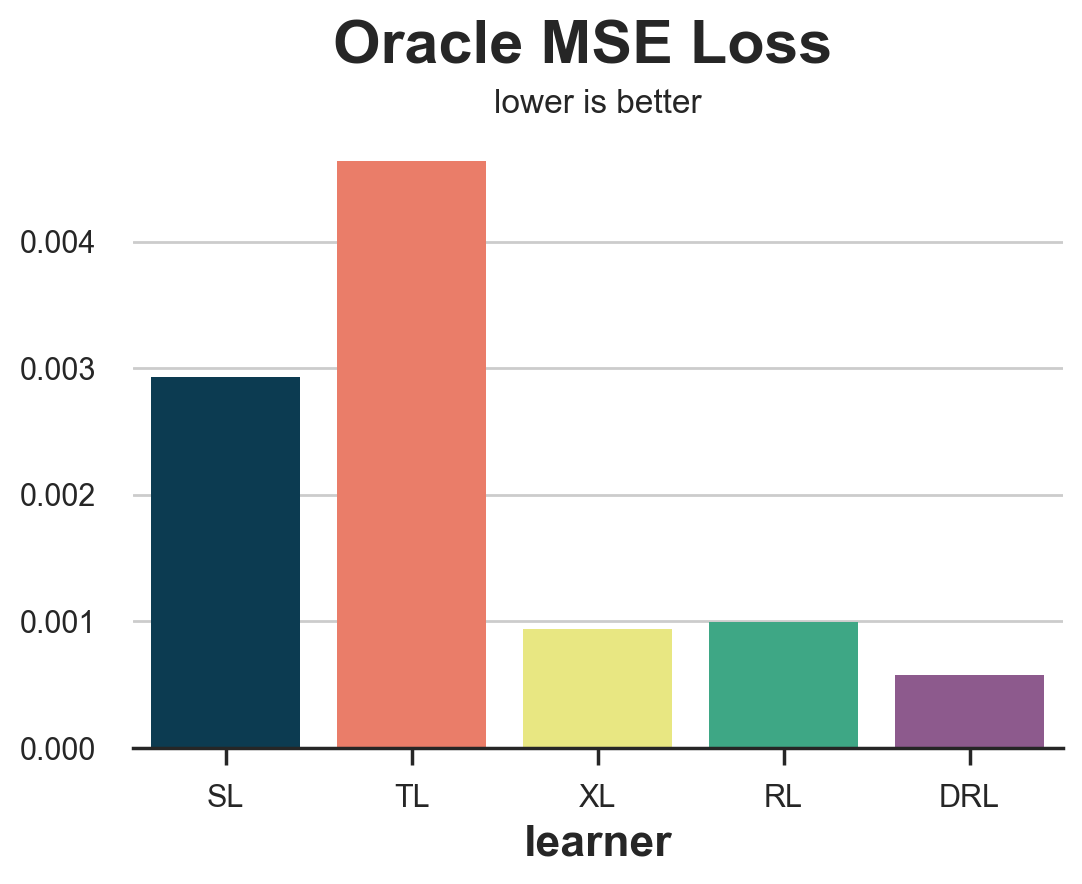

In [25]:
compare_methods(learners, names, loss_oracle_mse, title='Oracle MSE Loss')

In this case, we see that the T-learner clearly performs worst, while X-, D- and DR-learners perform best, with the R-learner slightly winning the race.

However, this might not be the best loss function. In fact, uplift modeling is just an intermediate step towards our ultimate goal: improving revenue.

### Oracle Policy Loss

Since our ultimate goal is to improve revenue, we could evaluate estimators by how much they increase revenue, given a certain policy function. Suppose, for example, that we had a $0.01\$$ cost of sending an email. Then, our policy would be to treat each costumer that has a predicted Conditional Average Treatment Effect above $0.01\$$. 

In [26]:
c = 0.01

How much would our revenue actually increase?

$$
\mathcal{L} _ {oracle-POLICY}(\hat{\tau}) = \frac{1}{n} \sum _ {i=1}^{n} \Big( \hat{\tau}(X_i) - \tau(X_i) \Big)^2
$$

Again, this is an "oracle" loss function that **cannot be computed** in reality since we do not observe the individual treatment effects. 

In [29]:
def loss_oracle_policy(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau_hat = learner.effect(data[X])
    return np.sum(data['effect_on_sales'] * (tau_hat>c) - c)

,learner,loss
0,SL,-5.00
1,TL,0.76
2,XL,8.61
3,RL,7.66
4,DRL,9.48


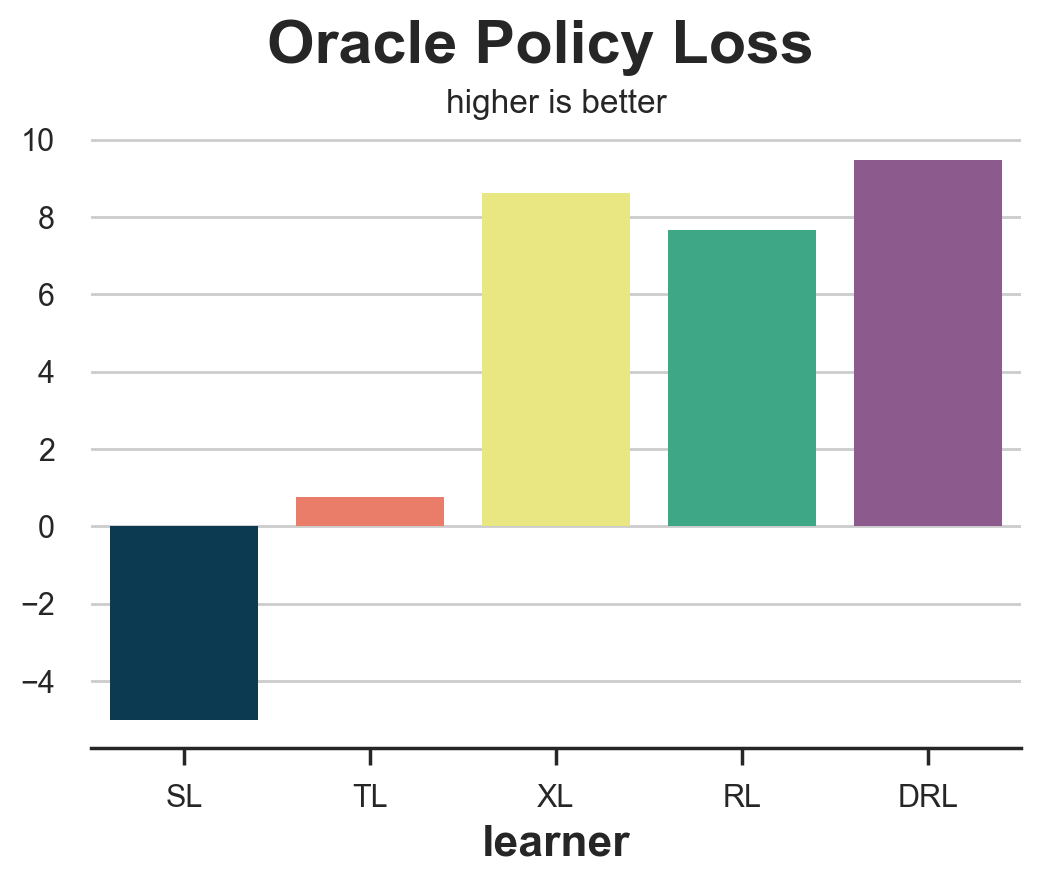

In [30]:
compare_methods(learners, names, loss_oracle_policy, title='Oracle Policy Loss', subtitle='higher is better')

In this case, the S-learner is clearly the worst performer, leading to an aggregate loss (i.e. we would have been better off not sending any email). On the other hand, X-, R- and DR- learners all lead to aggregate gains, with no clear winner

## Practical Losses

In the previous section, we have seen two examples of loss functions that we would like to compute if we could observe the Individual Treatment Effects $\tau_i$. However, in practice, even with a randomized experiment and even with a validation set, we do not observe the ITE,our object of interest. We will now cover some measures that try to evaluate uplift models, given this practical constraint.

### Outcome Loss

The first and simplest approach is to switch to a different loss variable. While we cannot observe the Individual Treatment Effects, $\tau_i$, we can still observe our outcome $y_i$. This is not exactly our object of interest, but we might expect an uplift model that performs well in terms of predicting $y$ to also produce good estimates of $\tau$.

One such loss function could be the **Outcome MSE loss**, which is the usual MSE loss function for prediction methods.
$$
\mathcal{L}_{Y}(\hat{\mu}) = \frac{1}{n} \sum _ {i=1}^{n} \Big( \hat{\mu}(X_i, W_i) - Y_i \Big)^2
$$

In [31]:
def loss_outcome(learner):
    data = generate_data(N=10_000, seed=123)
    mu0, mu1 = learner.predict_mu(data, X, W, Y)
    mu = mu0 * (1-data[W]) + mu1 * data[W]
    return np.mean((mu - data['sales'])**2)

### Distribution Loss

A different approach is to ask: how well are we able to match the distribution of potential outcomes? 

$$
dist \ \Big( \ \{Y_i | W_i=0 \} \ , \ \{Y_i - \hat{\tau}(X_i)| W_i=1 \} \ \Big)
$$

or 

$$
dist \ \Big( \ \{Y_i + \hat{\tau}(X_i)| W_i=0 \} \ , \ \{Y_i | W_i=1 \} \ \Big)
$$

In [34]:
def loss_dist(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau = learner.effect(data[X])
    y0 = data.loc[data.mail==1, 'sales'] - tau[data.mail==1]
    return sp.stats.energy_distance(df.loc[df.mail==0, 'sales'], y0)

,learner,loss
0,SL,0.270696
1,TL,0.329000
2,XL,0.300954
3,RL,0.313410
4,DRL,0.304305


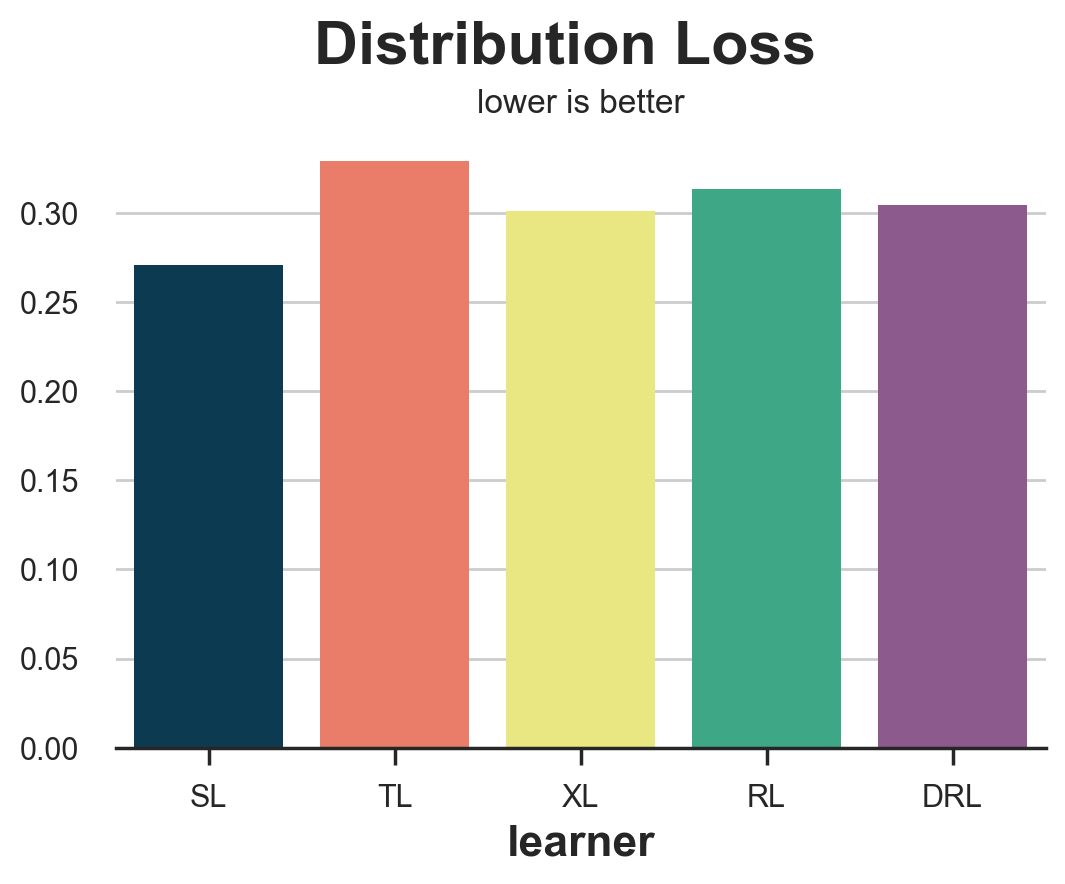

In [35]:
compare_methods(learners, names, loss_dist, 'Distribution Loss')

### Above-below Median Loss

The above-below median loss tries to answer the question: is our uplift model detecting *any* heterogeneity? In particular, if we take the validation set and we split the sample into above-median and below median predicted uplift $\hat{\tau}(x)$, how big is the actual difference in average effect, estimated with a difference-in-means estimator? We would expect better estimators to better split the sample into high-effects and low-effects. 

In [40]:
from statsmodels.formula.api import ols 

def loss_ab(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau = learner.effect(data[X]) + np.random.normal(0, 1e-8, len(data))
    data['above_median'] = tau >= np.median(tau)
    param = ols('sales ~ mail * above_median', data=data).fit().params[-1]
    return param

,learner,loss
0,SL,-0.008835
1,TL,0.222017
2,XL,0.093177
3,RL,0.134629
4,DRL,0.076508


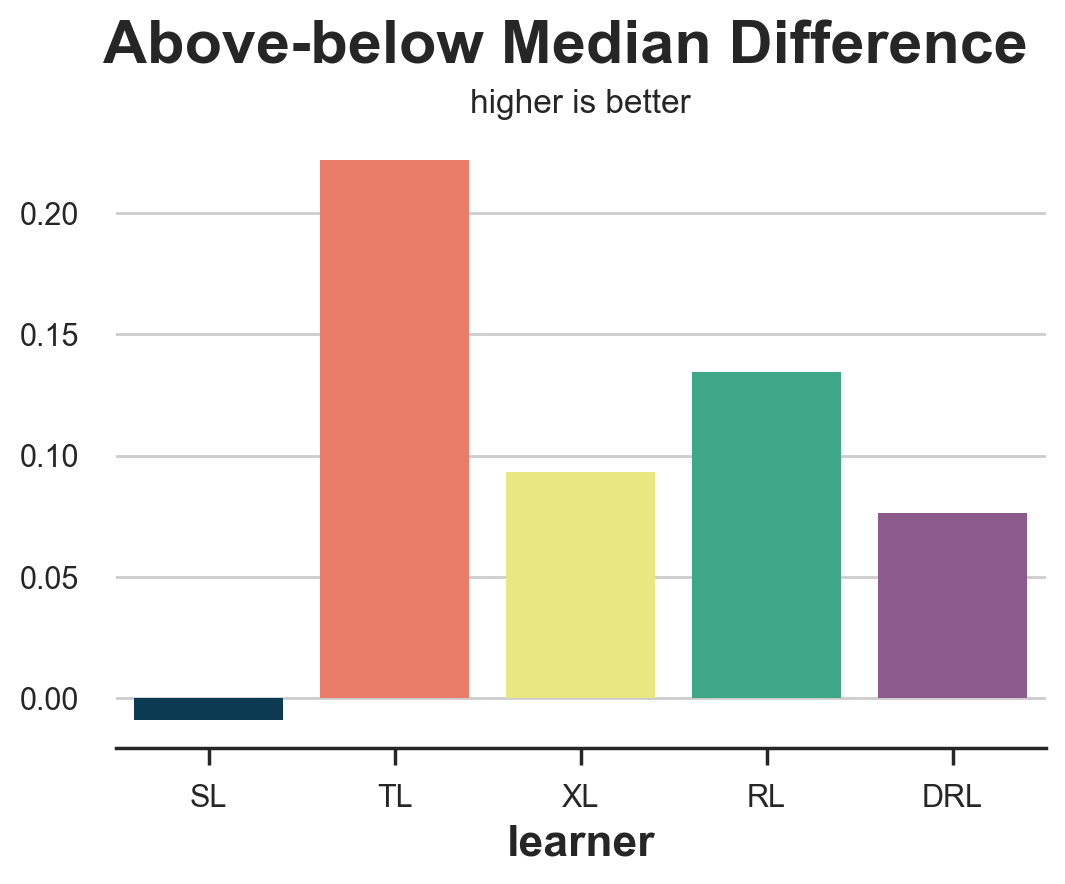

In [41]:
compare_methods(learners, names, loss_ab, title='Above-below Median Difference', subtitle='higher is better')

It's important to note that the difference-in-means estimators in the two groups (above- and below- median $\hat{\tau}(x)$) are **not guaranteed to be unbiased**, even if the data came from a randomized experiment. In fact, we have split the two groups on a variable, $\hat{\tau}(x)$, that is highly endogenous. Therefore, the method should be used with a grain of salt.

### Uplift Curve

An extension of the above-below median test is the **uplift curve**. The idea is simple: instead of splitting the sample into two goups based on the median (0.5 quantile), why not splitting the data into more groups (more quantiles)?

For each group, we compute the difference-in-means estimate and we plot its cumulative sum agains the corresponding quantile. The result is called **uplift curve**. The interpretation is simple: the higher the curve, the better we are able to separate high- from low-effect observations. However, also the same **disclaimer** applies: the difference-in-means estimates are not unbiased, therefore have to be used with a grain of salt.

In [71]:
def generate_uplift_curve(df):
    Q = 20
    df_q = pd.DataFrame()
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    ate = np.mean(data[Y][data[W]==1]) - np.mean(data[Y][data[W]==0])
    for learner, name in zip(learners, names):
        data['tau_hat'] = learner.effect(data[X])
        data['q'] = pd.qcut(-data.tau_hat + np.random.normal(0, 1e-8, len(data)), q=Q, labels=False)
        for q in range(Q):
            temp = data[data.q <= q]
            uplift = (np.mean(temp[Y][temp[W]==1]) - np.mean(temp[Y][temp[W]==0])) * q / (Q-1)
            df_q = pd.concat([df_q, pd.DataFrame({'q': [q], 'uplift': [uplift], 'learner': [name]})], ignore_index=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    sns.lineplot(x=range(Q), y=ate*range(Q)/(Q-1), color='k', ls='--', lw=3)
    sns.lineplot(x='q', y='uplift', hue='learner', data=df_q);
    plt.suptitle('Uplift Curve', y=1.02, fontsize=28, fontweight='bold')
    plt.title('higher is better', fontsize=14, fontweight=None, y=0.96)

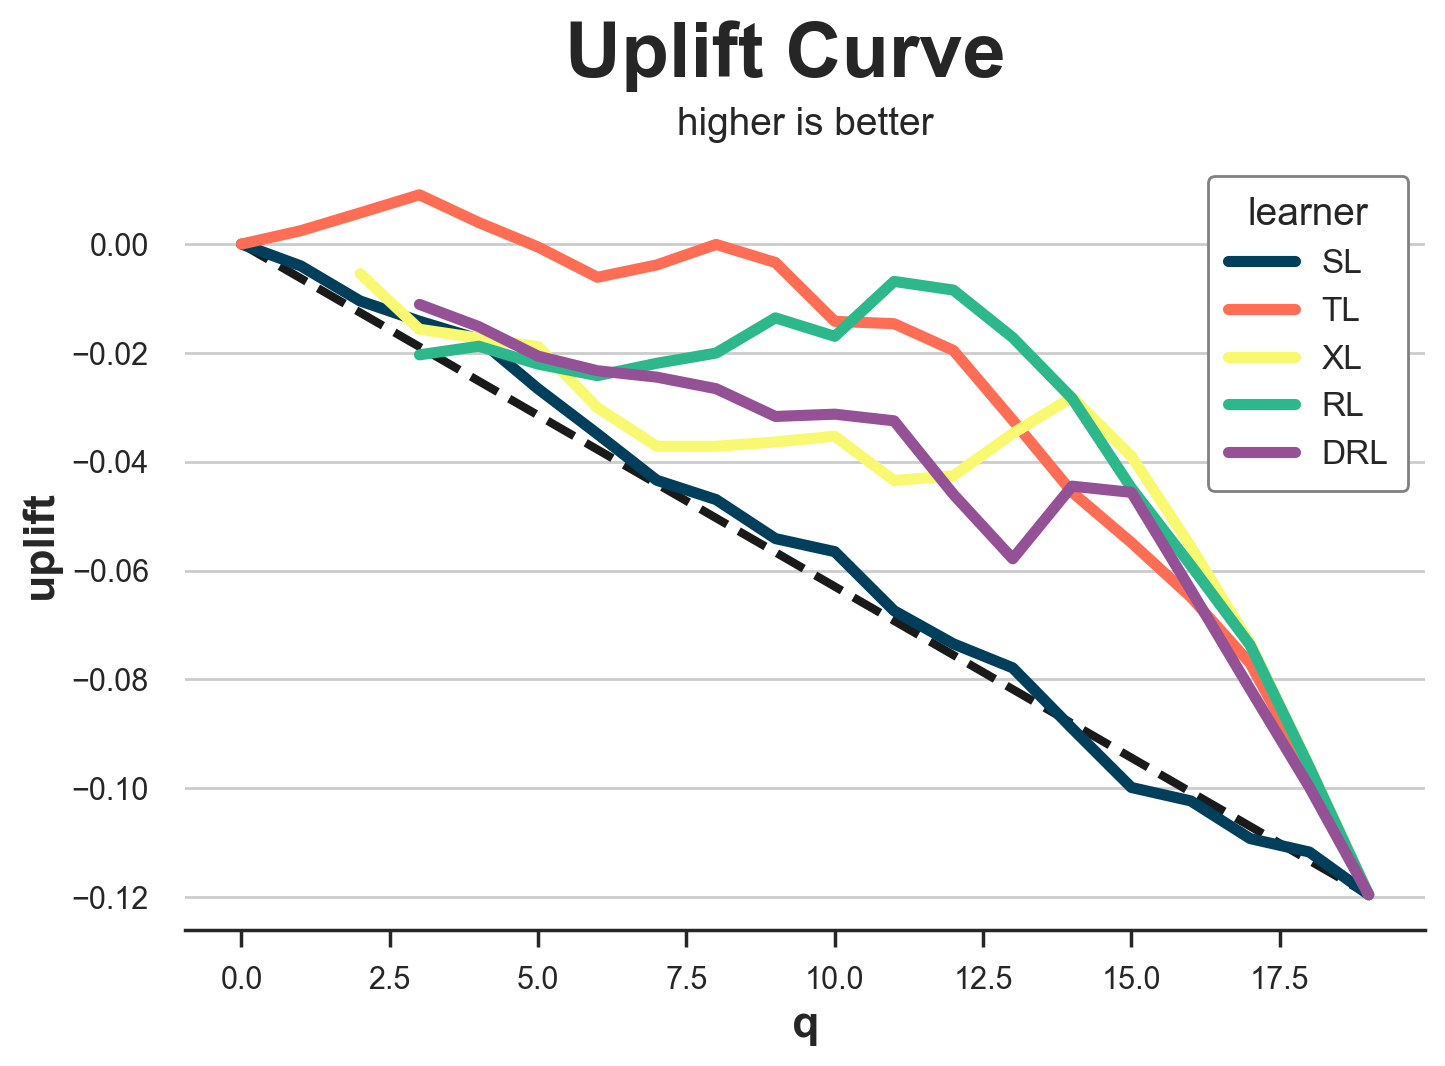

In [72]:
generate_uplift_curve(df)

While probably not the best method to *evaluate* uplift models, the uplift curve is very important in *understanding* and *implementing* them. In fact, for each models, it tells us that is the expected average treatment effect (y-axis) as we increase the share of treated population (x-axis).

### Nearest Neighbor Match

The last methods we analyzed aggregated data in order to understand whether the methods work on larger groups. The nearest neighbor match tries instead to understand how well an uplift model predicts individual treatment effects. However, since the ITEs are not observable, it tries to build a proxy by matching treated and control observations on observable characteristics $x$.

For example, if we take all treated observations ($i: W_i=1$), and we find the nearest neighbor in the control group ($NN_0(X_i)$), the corresponding MSE loss function is
$$
\mathcal{L} _ {NN}(\hat{\tau}) = \frac{1}{n} \sum _ {i: W_i=1} \Big( \hat{\tau}(X_i) - (Y_i - NN_0(X_i)) \Big)^2
$$

In [73]:
from scipy.spatial import KDTree

def loss_nn(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau_hat = learner.effect(data[X])
    nn0 = KDTree(data.loc[data[W]==0, X].values)
    control_index = nn0.query(data.loc[data[W]==1, X], k=1)[-1]
    tau_nn = data.loc[data[W]==1, Y].values - data.iloc[control_index, :][Y].values
    return np.mean((tau_hat[data[W]==1] - tau_nn)**2)

,learner,loss
0,SL,0.050478
1,TL,0.051301
2,XL,0.047102
3,RL,0.046684
4,DRL,0.046652


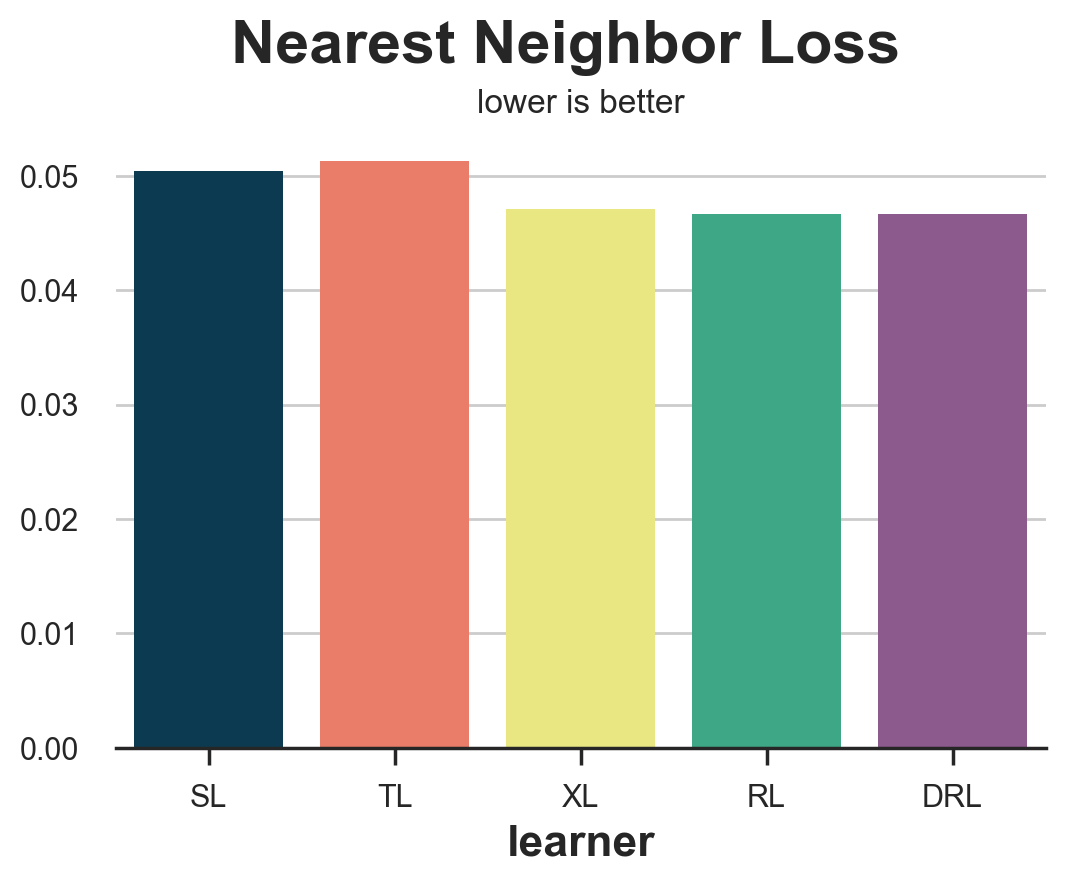

In [74]:
compare_methods(learners, names, loss_nn, title='Nearest Neighbor Loss')

### IPW Loss

The Inverse Probability Weighting (IPW) loss function was first proposed by [Gutierrez, Gerardy (2017)](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf) and the first of three metrics that we are going to see that uses a **pseudo-outcome** $Y^*$ to evaluate the estimator. As we have seen in the brief introduction to the R- and DR- learner, pseudo-outcomes are variables whose expected value is the Conditional Average Treatment Effect. The pseudo-outcome corresponding to the IPW loss is

$$
\mathcal{L} _ {IPW} = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{\tau}(X_i) - Y_i \ \frac{W_i - \hat{e}(X_i)}{\hat{e}(X_i)(1 - \hat{e}(X_i))} \right)^2
$$

In [54]:
def loss_ipw(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau_hat = learner.effect(data[X])
    e_hat = clone(model_e).fit(data[X], data[W]).predict_proba(data[X])[:,1]
    tau_gg = data[Y] * (data[W] - e_hat) / (e_hat * (1 - e_hat))
    return np.mean((tau_hat - tau_gg)**2)

,learner,loss
0,SL,1.170917
1,TL,1.153752
2,XL,1.172517
3,RL,1.172934
4,DRL,1.171769


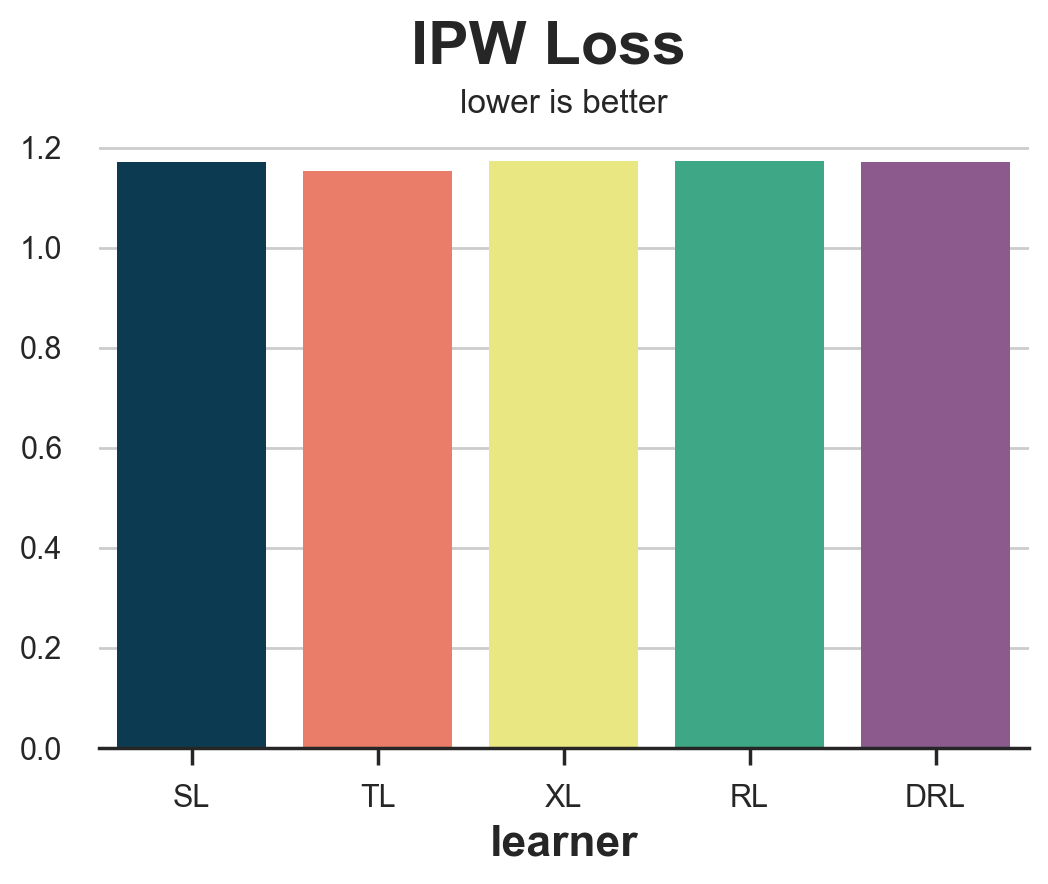

In [55]:
compare_methods(learners, names, loss_ipw, title='IPW Loss')

### R Loss

The R-loss was introduced together with the R-learner by [Nie, Wager (2017)](https://arxiv.org/abs/1712.04912), and it is essentially the **objective function** of the R-learner.

$$
\mathcal{L}_{R} = \frac{1}{n} \sum _ {i=1}^{n} \left( \hat{\tau}(X_i) -  \frac{Y_i - \hat{\mu}_W(X_i)}{W_i - \hat{e}(X_i)} \right)^2
$$

In [57]:
def loss_r(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau_hat = learner.effect(data[X])
    y_hat = clone(model_y).fit(df[X + [W]], df[Y]).predict(data[X + [W]])
    e_hat = clone(model_e).fit(df[X], df[W]).predict_proba(data[X])[:,1]
    tau_nw = (data[Y] - y_hat) / (data[W] - e_hat)
    return np.mean((tau_hat - tau_nw)**2)

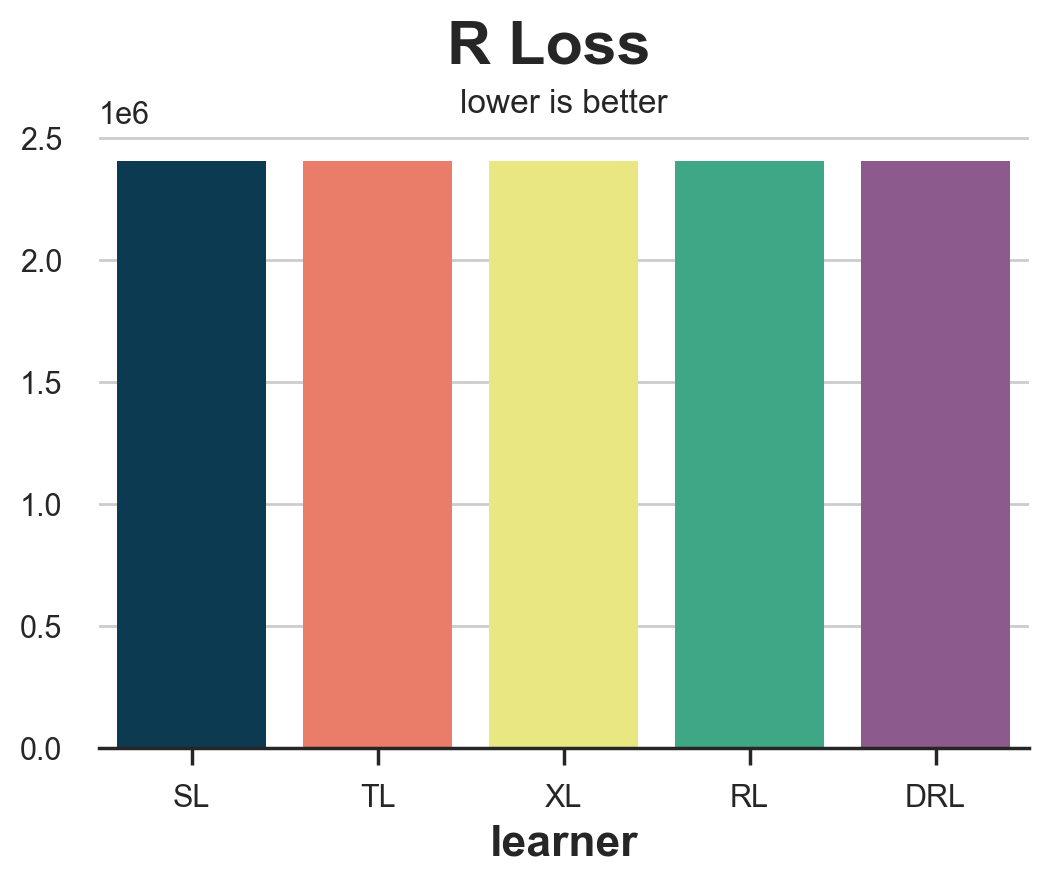

In [58]:
results = compare_methods(learners, names, loss_r, title='R Loss')

Unsurprisingly, the R-loss tends to favor its corresponding learner, the R-learner.

### DR Loss

Similarly to the R-loss, the DR-loss is the **objective function** of the DR-learner and it was first introduced by [Saito, Yasui (2020)](https://arxiv.org/abs/1909.05299).

$$
\mathcal{L} _ {DR} = \frac{1}{n} \sum _ {i=1}^{n} \left( \hat{\tau}(X_i) - \hat{\mu}_1(X_i) + \hat{\mu}_0(X_i) - (Y_i - \hat{\mu}_W(X_i)) \ \frac{W_i - \hat{e}(X_i)}{\hat{e}(X_i)(1 - \hat{e}(X_i))} \right)^2
$$

In [60]:
def loss_dr(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau_hat = learner.effect(data[X])
    y_hat = clone(model_y).fit(df[X + [W]], df[Y]).predict(data[X + [W]])
    mu1 = clone(model_y).fit(df[X + [W]], df[Y]).predict(data[X + [W]].assign(mail=1))
    mu0 = clone(model_y).fit(df[X + [W]], df[Y]).predict(data[X + [W]].assign(mail=1))
    e_hat = clone(model_e).fit(df[X], df[W]).predict_proba(data[X])[:,1]
    tau_nw = mu1 - mu0 + (data[Y] - y_hat) * (data[W] - e_hat) / (e_hat * (1 - e_hat))
    return np.mean((tau_hat - tau_nw)**2)

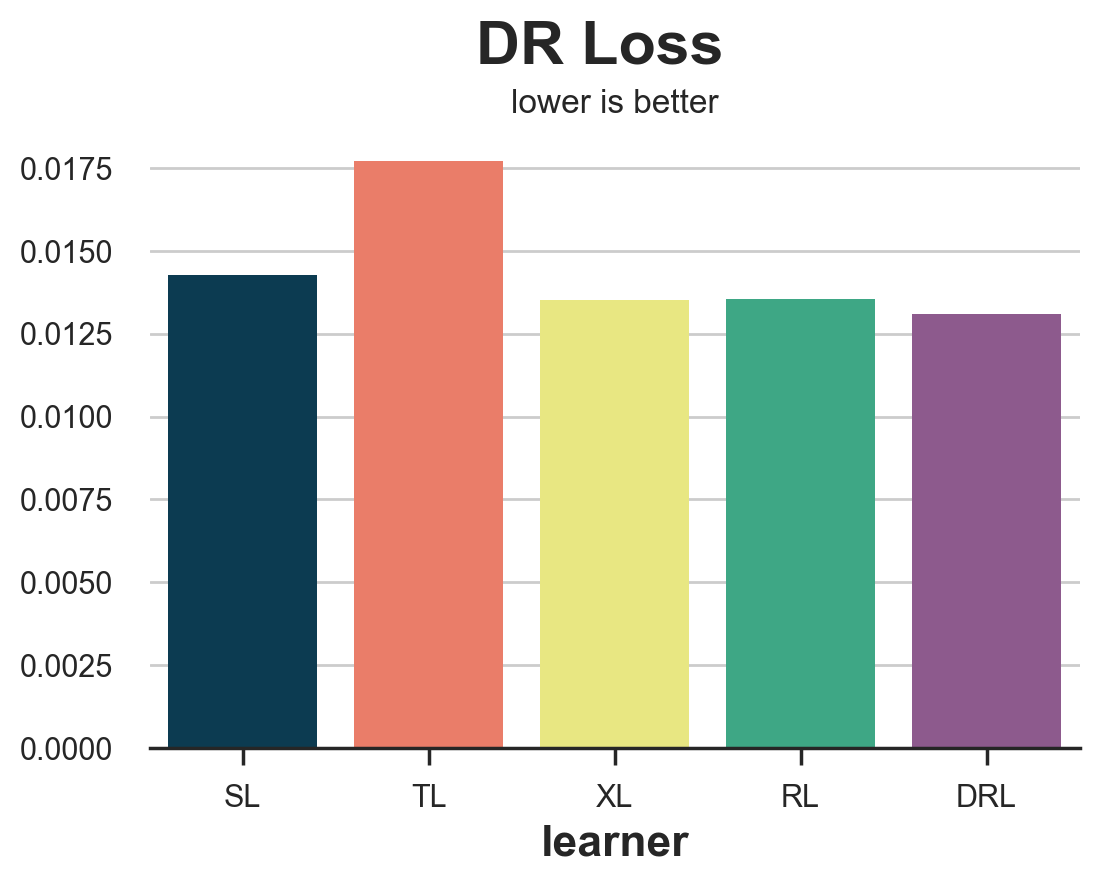

In [61]:
results = compare_methods(learners, names, loss_dr, title='DR Loss')

As for the R-loss, the DR-loss tends to favor its corresponding learner, the DR-learner.

### Empirical Policy Loss

The last loss function that we are going to analyze is different from all the others we have seen so far since it focuses not on how well we are able to estimate the treatment effects, but rather on how well would the corresponding **optimal treatment policy** performs. In particular, [Hitsch, Misra, Zhang (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3111957) propose the following loss function:

$$
\mathcal{L} _ {TEP} = \frac{1}{n} \sum _ {i=1}^{n} \left( W_i \cdot d(X_i) \cdot \frac{Y_i - c}{\hat{e}(X_i)} + (1-W_i) \cdot (1-d(X_i)) \cdot \frac{Y_i}{1-\hat{e}(X_i)} \right)
$$

where $c$ is the treatment cost and $d_i$ is the optimal treatment policy given the estimated CATE $\hat{\tau}(X_i)$. In our case, we assume an individual treatment cost of $c=0.01\$$, so that the optimal policy is to treat every customer with an estimated CATE larger than 0.01, $d(X_i) = (\hat{\tau}(X_i) > 0.01)$.

The terms $W_i \cdot d(X_i)$ and $(1-W_i) \cdot (1-d(X_i))$ imply that we use for the calculation only individuals for whom the actual treatment *W* corresponds with the optimal one, *d(X)*.

In [63]:
def loss_policy(learner):
    data = dgp.generate_data(seed_data=1, seed_assignment=1, keep_po=True)
    tau_hat = learner.effect(data[X])
    e_hat = clone(model_e).fit(data[X], data[W]).predict_proba(data[X])[:,1]
    d = tau_hat > c
    return np.sum((d * data[W] * (data[Y]-c)/ e_hat + (1-d) * (1-data[W]) * data[Y] / (1-e_hat)))

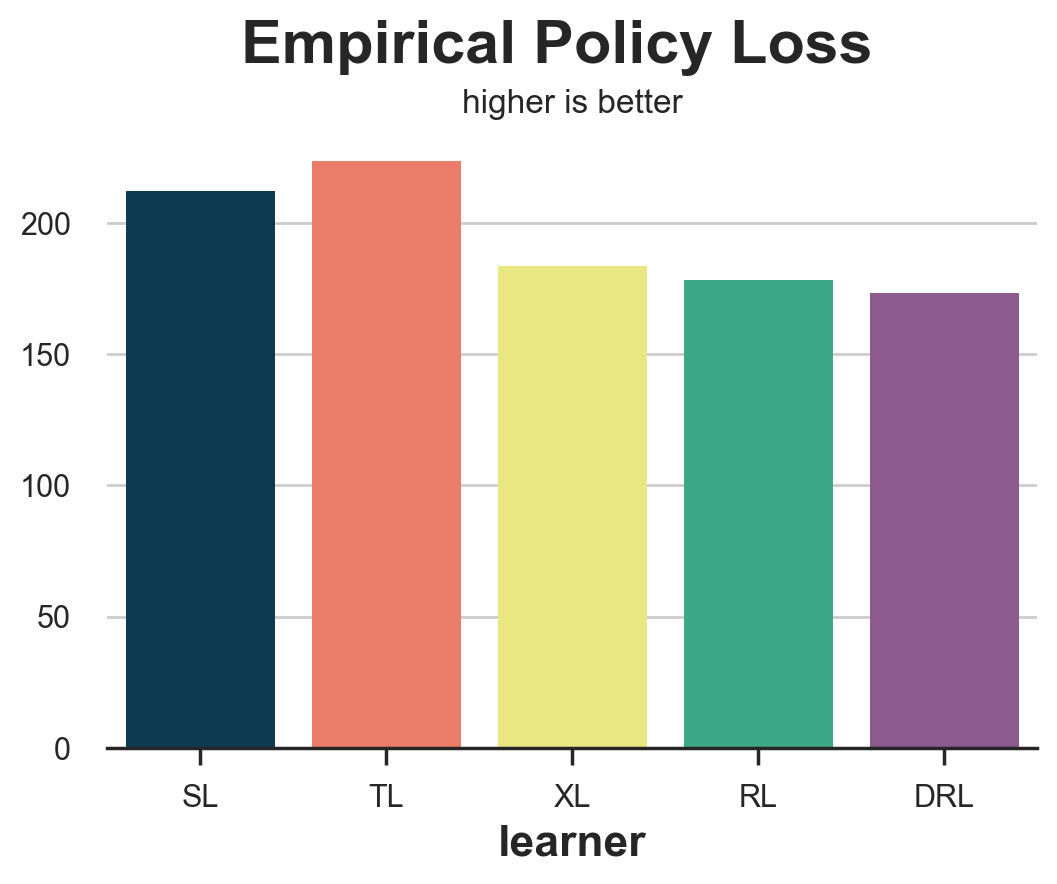

In [64]:
results = compare_methods(learners, names, loss_policy, title='Empirical Policy Loss', subtitle='higher is better')

## Meta Studies

In this article we have introduced a wide variety of methods to evaluate uplift models, a.k.a. Conditional Average Treatment Effect estimators. We have also tested in our simulated dataset, which is a very special and limited example. How do these metrics **perform** in general? 

[Schuler, Baiocchi, Tibshirani, Shah (2018)](https://arxiv.org/abs/1804.05146) compares the S-loss, T-loss, R-loss, on simulated data, for the corresponding estimators. They find that the R-loss "*is the validation set metric that, when optimized, most consistently leads to the selection of a high-performing model*".

[Curth, van der Schaar (2023)](https://arxiv.org/abs/2302.02923) studies a broader array of learners from a **theoretical perspective**. They find that "*no existing selection criterion is globally best across all experimental conditions we consider*". However, they notice that S- and T-learners tend to perform better when the conditional expectation functions $\mu(X)$ are easier to predict than the CATE $\tau(X)$, while the R- and DR-learners perform better in the opposite scenario. The X-learner performs best when both functions are equally complex. The **intuition** is that the S- and T- learner focus of modeling $y$, while the R- and DR- learner focus on modeling $\tau$.

[Mahajan, Mitliagkas, Neal, Syrgkanis (2023)](https://arxiv.org/abs/2211.01939) is the **most comprehensive** study in terms of scope. The authors compare many metrics on 144 datasets and 415 estimators. They find that “*no metric significantly dominates the rest*” but “*metrics that use DR elements seem to always be among the candidate winners*”.

## Conclusion

In this article, we have explore multiple methods to evaluate uplift models. The **main challenge** is the unobservability of the variable of interest, the Individual Treatment Effects. Therefore, different methods try to evaluate uplift models either using other variables, using proxy outcomes, or approximating the effect of implied optimal policies.

It is hard to recommend using a single method since there is **no consensus** on which one performs best, neither from a theoretical nor from an empirical perspective. Loss functions that use R-learner and DR-learner tend to perform **consistently better**, but are also biased towards the corresponding learners. Understanding how these metrics work however, can help understanding their biases and limitation, in order to take the most appropriate decisions depending on the specific scenario. 

It is also important to underline that metrics such as the uplift curve can be very useful in *understanding* and *explaining* estimators, but might not be best to *evaluate* or *compare* them. 

### References

- Curth, van der Schaar (2023), ["In Search of Insights, Not Magic Bullets: Towards Demystification of the Model Selection Dilemma in Heterogeneous Treatment Effect Estimation"](https://arxiv.org/abs/2302.02923)

- Gutierrez, Gerardy (2017), ["Causal Inference and Uplift Modeling: A review of the literature"](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)

- Hitsch, Misra, Zhang (2023), ["Heterogeneous Treatment Effects and Optimal Targeting Policy Evaluation"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3111957)

- Kennedy (2022), ["Towards optimal doubly robust estimation of heterogeneous causal effects"](https://arxiv.org/abs/2004.14497)

- Kunzel, Sekhon, Bickel, Yu (2017), ["Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"](https://arxiv.org/abs/1706.03461)

- Mahajan, Mitliagkas, Neal, Syrgkanis (2023), ["Empirical Analysis of Model Selection for Heterogeneous Causal Effect Estimation"](https://arxiv.org/abs/2211.01939)

- Nie, Wager (2017), ["Quasi-Oracle Estimation of Heterogeneous Treatment Effects"](https://arxiv.org/abs/1712.04912)

- Saito, Yasui (2020), ["Counterfactual Cross-Validation: Stable Model Selection Procedure for Causal Inference Models"](https://arxiv.org/abs/1909.05299)

- Schuler, Baiocchi, Tibshirani, Shah (2018), ["A comparison of methods for model selection when estimating individual treatment effects"](https://arxiv.org/abs/1804.05146)

### Related Articles

- [Understanding Meta Learners](https://towardsdatascience.com/8a9c1e340832)

- [Understanding AIPW, the Doubly-Robust Estimator](https://towardsdatascience.com/ed4097dab27a)

- [Understanding Causal Trees](https://towardsdatascience.com/920177462149)

- [From Causal Trees to Forests](https://towardsdatascience.com/43c4536f1481)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/evaluate_uplift.ipynb